In [1]:
import numpy as np
from scipy.special import logit,expit
import collections
import matplotlib.pyplot as plt

N=200
P=3
betat1=np.array([1 , 1 , 1])
betat2=np.array([3 , 3 , 3])
betat=np.array([betat1,betat2])

np.random.seed(123)
mu=np.array([-1,-1,-1])
cov=np.array([[2,0.5,0.5],[0.5,2,0.5],[0.5,0.5,2]])
X=np.random.multivariate_normal(mu,cov,N,check_valid='raise')

In [2]:
def g(x,y):
    y=np.dot(x,y)
    return y

def f(x,y):
    y=np.dot(x,y)
    return y

def pi(x,y):
    y=expit(g(x,y))
    return y

def phi(x,y):
    y=expit(f(x,y))
    return y

def I0(y):
    if y==0:
        return 1

In [3]:
N=500
P=1

betat1=np.array(1.27745888)
betat2=np.array(-0.07740899)
betat=np.array([betat1,betat2])

np.random.seed(123)
X=5*np.random.rand(N)-2

Y=np.zeros(N)
tgroup=np.zeros(N)
pgroup=np.zeros((N,2))
for i in range(N):
    a=np.random.rand()
    b=pi(X[i],betat1)
    pgroup[i,0]=b
    if a>=b:
        tgroup[i]=1
        c=np.random.rand()
        d=phi(X[i],betat2)
        pgroup[i,1]=d
        if c>=d:
            Y[i]=1

In [4]:
N=500
P=1

betat3=np.array(0.3)
betat4=np.array(1)
betatt=np.array([betat3,betat4])

np.random.seed(123)
X1=np.random.normal(1,1,N)

Z=np.zeros(N)
Ztgroup=np.zeros(N)
Zpgroup=np.zeros((N,2))
for i in range(N):
    a=np.random.rand()
    b=pi(X[i],betat3)
    Zpgroup[i,0]=b
    if a>=b:
        Ztgroup[i]=1
        c=np.random.rand()
        d=phi(X[i],betat4)
        Zpgroup[i,1]=d
        if c>=d:
            Z[i]=1

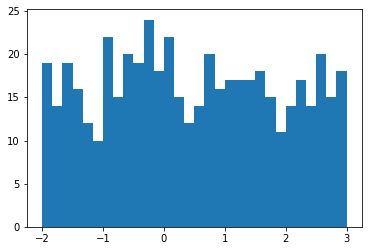

In [5]:
plt.hist(X,bins=30)
plt.show()

In [6]:
collections.Counter(Z),collections.Counter(Ztgroup)

(Counter({0.0: 392, 1.0: 108}), Counter({1.0: 213, 0.0: 287}))

In [7]:
collections.Counter(Y),collections.Counter(tgroup)

(Counter({0.0: 408, 1.0: 92}), Counter({0.0: 302, 1.0: 198}))

In [8]:
#E-step
def Lih(X,beta):
    Ga=np.zeros((N,2))

    for i in range(N):#响应度
        if Y[i]==1:
            Ga[i,0]=0
            Ga[i,1]=1
        elif Y[i]==0:
            a=(expit(np.dot(X[i],beta[0])))
            b=(1-a)*(1-expit(np.dot(X[i],beta[1])))
            Ga[i,0]=a/(a+b)
            Ga[i,1]=1-Ga[i,0]

    return Ga

In [9]:
AS=Lih(X1,betat)
np.array(np.where(AS[:,0]>=pgroup[:,0])).shape

(1, 253)

In [10]:
#M-step
def Q(X,Y,beta):
    Ga=Lih(X,beta)
    A=np.zeros(N)
    for i in range(N):
        pi=expit(np.dot(beta[0],X[i]))
        phi=expit(np.dot(beta[1],X[i]))
        if Y[i]==0:
            A[i]=(Ga[i,0])*np.log(pi)+(Ga[i,1])*np.log((1-pi)*(1-phi))
            #A[i]=Ga[i,0]*np.log(pi)+Ga[i,1]*np.log((1-pi)*(1-phi))
            #A[i]=(Ga[i,0]*np.log(pi))+(Ga[i,1]*(np.log(1-pi)+np.log(1-phi)))
        else:
            A[i]=(Ga[i,1])*np.log((1-pi)*(phi))
            #A[i]=Ga[i,0]*np.log(pi)+Ga[i,1]*np.log((1-pi)*(1-phi))
            #A[i]=(Ga[i,0]*np.log(pi))+(Ga[i,1]*(np.log(1-pi)+np.log(phi)))
        #A[i]=(Ga[i,0]*(1-Y[i])*np.log(pi))+(Ga[i,1]*(np.log(1-pi)+np.log(1-phi)+Y[i]*np.dot(X[i],beta[1])))
    Q=np.sum(A)
    return Q

def grad(X,Y,Ga,beta):
    A=np.zeros((N,P))
    B=np.zeros((N,P))
    for i in range(N):
        A[i]=((Ga[i,0]*(1-Y[i]))*(1-expit(np.dot(beta[0],X[i])))-(Ga[i,1]*expit(np.dot(beta[0],X[i]))))*X[i]
        B[i]=(Ga[i,1]*(Y[i]-expit(np.dot(beta[1],X[i]))))*X[i]
    grad1=np.sum(A,axis=0)
    grad2=np.sum(B,axis=0)
    grad=np.array([grad1,grad2])
    return grad



In [66]:
def dgra(X,Y,ibeta,n=1000,t=0.01,xim=0.6,yim=0.3,zim=0.000001):#梯度下降（回溯梯度下降法）
    
    L=Lih(X,ibeta)#E-step
    for i in range(n):#M-step
        lik1=Q(X,Y,ibeta)
        ibeta=ibeta+t*grad(X,Y,L,ibeta)
        lik=Q(X,Y,ibeta)
        d=np.r_[ibeta[0],ibeta[1]]
        c=np.dot(d,d)
        b=(lik-lik1)
        if b>=yim*t*c:
            t=xim*t
        if c<=zim:
            break
    return ibeta


#def dgra1(X,Y,ibeta,n=1000,a=0.01,yim=0.2,zim=0.001):
    
    for i in range(n):
        lik1=Q(X,Y,ibeta)
        L=Lih(X,ibeta)#E-step
        ibeta=ibeta+a*grad(X,Y,L,ibeta)
        lik=Q(X,Y,ibeta)
        d=np.r_[ibeta[0],ibeta[1]]
        c=np.dot(d,d)
        b=(lik-lik1)
        if b>=yim*a*c:
            a=0.5*a
        if c<=zim:
            break
    return ibeta

In [12]:
betat,betatt

(array([ 1.27745888, -0.07740899]), array([0.3, 1. ]))

In [63]:
#initial value
beta01=[2.75]
beta02=[1]
beta0=np.array([beta01,beta02])

In [64]:
Q(X,Y,betat),Q(X,Y,betatt),Q(X,Y,beta0)

(-377.3027814418117, -462.8283787291805, -309.41320107165836)

In [68]:
dgra(X,Y,beta0)

array([[2.06844479],
       [0.58320862]])

In [69]:
EMbeta=beta0
for i in range(5):
    lik1=Q(X,Y,EMbeta)
    EMbeta=dgra(X,Y,EMbeta)
    lik=Q(X,Y,EMbeta)
    print(i)
EMbeta,Q(X,Y,EMbeta)

0
1
2
3
4


(array([[1.51426631],
        [0.40221009]]),
 -343.8260908389892)

In [16]:
ZX=Lih(X,EMbeta)

In [17]:
np.array(np.where(tgroup[:]==0)).shape

(1, 302)

In [18]:
np.array(np.where(ZX[:,0]>=ZX[:,1])).shape

(1, 295)

In [19]:
np.array(np.where(AS[:,0]>=AS[:,1])).shape

(1, 382)

In [20]:
np.array(np.where(ZX[:,0]>=pgroup[:,0])).shape

(1, 350)